### Test on 2017

In [314]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RandomForestModel
from darts.metrics import mape, mae, rmse

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2010-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_20876\2106790095.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


### Linear model

In [321]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from darts.models import RegressionModel

# video method -> https://www.youtube.com/watch?v=9QtL7m3YS9I&ab_channel=PyData
model_test = RegressionModel(
    lags=52, # one year’s worth of weekly lags
    model=LinearRegression()
)

model_test.fit(train_ts)
rf_forecast = model_test.predict(n=len(test_ts))

### RF model

In [292]:
# build a 0,1,2,… index TimeSeries
import numpy as np
import pandas as pd
from darts import TimeSeries

time_idx = pd.Series(np.arange(len(series)), index=series.time_index)
time_ts  = TimeSeries.from_series(time_idx, freq=series.freq)

rf = RandomForestModel(
  lags=52,
  output_chunk_length=len(test_ts),
  lags_future_covariates=[0]
)
rf.fit(
  series=train_ts,
  future_covariates=time_ts[:train_ts.end_time()]
)
rf_forecast = rf.predict(
  n=len(test_ts),
  future_covariates=time_ts
)


In [ ]:
h = len(test_ts)
rf_model = RandomForestModel(
    lags=52, # one year’s worth of weekly lags
    output_chunk_length=1, # 1 is for recusive multi-step forecast, use output as input for next predict (arima and ets does this), not one shot like direct forecast
    n_estimators=300,
    random_state=42,
    )

rf_model.fit(train_ts)
rf_forecast = rf_model.predict(n=h)

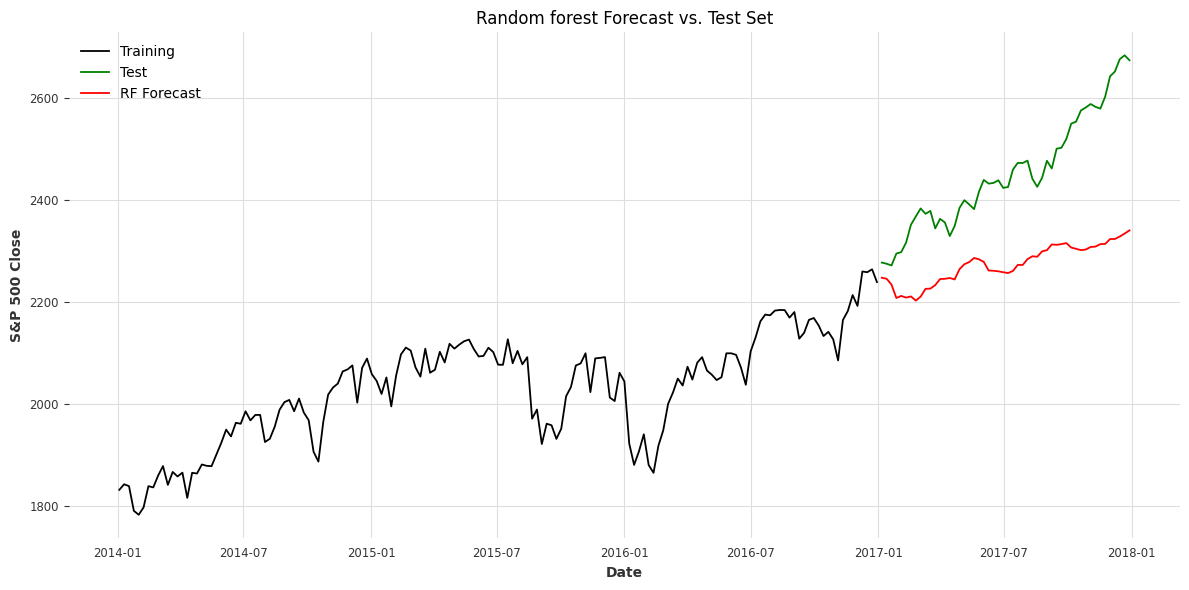

MAPE: 7.13%
MAE:  177.82
RMSE: 195.12


In [322]:
# get only the part of train_ts from 2014-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())

# plot
plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")
plt.plot(rf_forecast.time_index, rf_forecast.values(), label="RF Forecast", color="red")
plt.title("Random forest Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# evaluate
print(f"MAPE: {mape(test_ts, rf_forecast):.2f}%")
print(f"MAE:  {mae(test_ts, rf_forecast):.2f}")
print(f"RMSE: {rmse(test_ts, rf_forecast):.2f}")

### Test on 2023 and 2024

In [278]:
# load data
df = sp500.history(start="2014-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# Fix missing data
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2022) and test (2023-2024)
train_ts_2, test_ts_2 = series.split_before(pd.Timestamp("2023-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_20876\3240597983.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


### Linear model

In [ ]:
# linear model
model_test = RegressionModel(
    lags=52, # one year’s worth of weekly lags
    model=LinearRegression()
)

model_test.fit(train_ts_2)
rf_forecast_2 = model_test.predict(n=len(test_ts_2))

### RF model

In [ ]:
h = len(test_ts_2)
rf_model_2 = RandomForestModel(
    lags=52,          # one year’s worth of weekly lags
    n_estimators=300, # number of trees
    random_state=42,
    output_chunk_length=1
)

rf_model_2.fit(train_ts_2)
rf_forecast_2 = rf_model_2.predict(n=h)

In [288]:
time_idx = pd.Series(np.arange(len(series)), index=series.time_index)
time_ts  = TimeSeries.from_series(time_idx, freq=series.freq)

rf = RandomForestModel(
  lags=104,
  output_chunk_length=1,
  lags_future_covariates=[0]
)
rf.fit(
  series=train_ts_2,
  future_covariates=time_ts[:train_ts_2.end_time()]
)
rf_forecast_2 = rf.predict(
  n=len(test_ts_2),
  future_covariates=time_ts
)

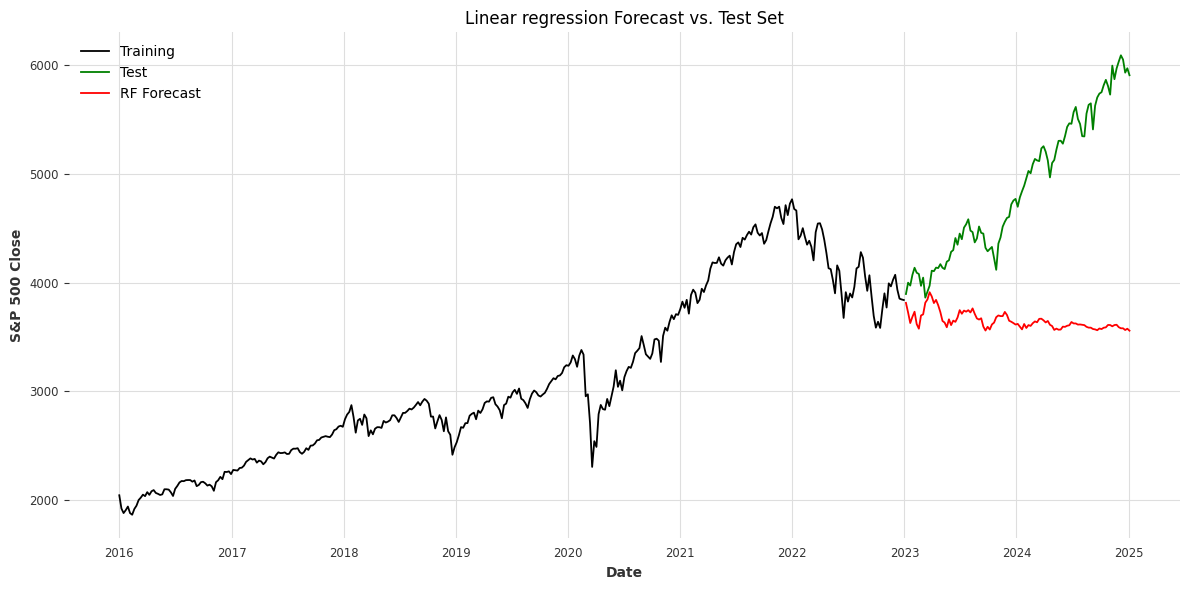

MAPE: 23.67%
MAE:  1225.05
RMSE: 1412.01


In [309]:
# get only the part of train_ts from 2016-01-01 onward
train_slice_2 = train_ts_2.slice(pd.Timestamp("2016-01-01"), train_ts_2.end_time())

# plot train, test, and RF forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice_2.time_index, train_slice_2.values(), label="Training")
plt.plot(test_ts_2.time_index,    test_ts_2.values(),    label="Test",      color="green")
plt.plot(rf_forecast_2.time_index, rf_forecast_2.values(), label="RF Forecast", color="red")
plt.title("Random forest Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

# compute metrics
print(f"MAPE: {mape(test_ts_2, rf_forecast_2):.2f}%")
print(f"MAE:  {mae (test_ts_2, rf_forecast_2):.2f}")
print(f"RMSE: {rmse(test_ts_2, rf_forecast_2):.2f}")

### Backtesting

In [324]:
df = sp500.history(start="2016-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

# resample to weekly
weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

C:\Users\USER\AppData\Local\Temp\ipykernel_20876\400281087.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [334]:
# back test period
backtest_start = pd.Timestamp("2024-01-01")
backtest_end   = pd.Timestamp("2024-12-31")

h = len(series[backtest_start:backtest_end])
rf_model_3 = RandomForestModel(
    lags=52,              # one year’s worth of weekly lags
    n_estimators=100,     # number of trees
    random_state=42,
    output_chunk_length=1 # 1-step forecasts
)

rf_model_3.fit(series[:backtest_start])

RegressionModel(lags=52, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=LinearRegression(), multi_models=True, use_static_covariates=True, random_state=None)

In [335]:
rf_backtest = rf_model_3.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,      # 1 week ahead
    stride=1,                # move forward one week each time
    retrain=True,            # re-fit at each fold
    last_points_only=True    # keep only the 1-week-ahead point
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


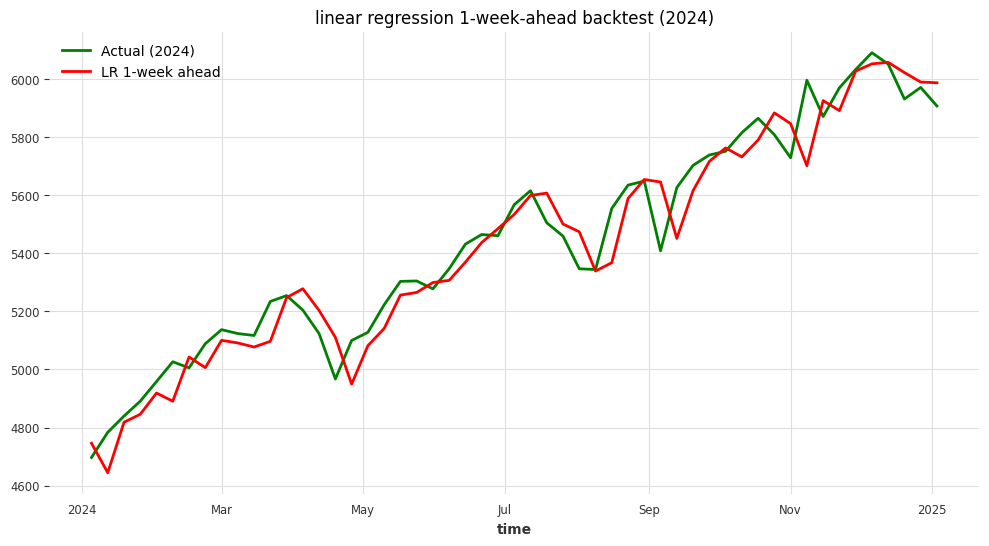

MAPE: 1.31%
MAE:  70.84
RMSE: 92.76


In [336]:
actuals_bt = series[backtest_start:backtest_end]

# plot actual vs RF forecasts
plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2024)", color="green")
rf_backtest.plot(label="RF 1-week ahead", color="red")
plt.legend()
plt.title("RF 1-week-ahead backtest (2024)")
plt.show()

# compute metrics
print(f"MAPE: {mape(actuals_bt, rf_backtest):.2f}%")
print(f"MAE:  {mae(actuals_bt, rf_backtest):.2f}")
print(f"RMSE: {rmse(actuals_bt, rf_backtest):.2f}")